# MODEL CNN - 2 klasy

In [11]:
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import torch
import torchaudio
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from torchvision import datasets, models, transforms
import pandas as pd
import os

In [3]:
data_path = './data/spectrograms_yes_no' #looking in subfolder train

yes_no_dataset = datasets.ImageFolder(
    root=data_path,
    transform=transforms.Compose([transforms.Resize((201,81)),
                                  transforms.ToTensor()
                                  ])
)
print(yes_no_dataset)

Dataset ImageFolder
    Number of datapoints: 4752
    Root location: ./data/spectrograms_yes_no
    StandardTransform
Transform: Compose(
               Resize(size=(201, 81), interpolation=bilinear, max_size=None, antialias=True)
               ToTensor()
           )


In [5]:
#split data to test and train
#use 80% to train
train_size = int(0.8 * len(yes_no_dataset))
test_size = len(yes_no_dataset) - train_size
yes_no_train_dataset, yes_no_test_dataset = torch.utils.data.random_split(yes_no_dataset, [train_size, test_size])

print("Training size:", len(yes_no_train_dataset))
print("Testing size:",len(yes_no_test_dataset))

Training size: 3801
Testing size: 951


In [6]:
train_dataloader = torch.utils.data.DataLoader(
    yes_no_train_dataset,
    batch_size=15,
    num_workers=2,
    shuffle=True
)

test_dataloader = torch.utils.data.DataLoader(
    yes_no_test_dataset,
    batch_size=15,
    num_workers=2,
    shuffle=True
)

In [8]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [9]:
class CNNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=5)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=5)
        self.conv2_drop = nn.Dropout2d()
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(51136, 50)
        self.fc2 = nn.Linear(50, 2)


    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
        #x = x.view(x.size(0), -1)
        x = self.flatten(x)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = F.relu(self.fc2(x))
        return F.log_softmax(x,dim=1)  

model = CNNet().to(device)

In [12]:
# cost function used to determine best parameters
cost = torch.nn.CrossEntropyLoss()

# used to create optimal parameters
learning_rate = 0.0001
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

# Create the training function

def train(dataloader, model, loss, optimizer):
    model.train()
    size = len(dataloader.dataset)
    for batch, (X, Y) in enumerate(dataloader):
        
        X, Y = X.to(device), Y.to(device)
        optimizer.zero_grad()
        pred = model(X)
        loss = cost(pred, Y)
        loss.backward()
        optimizer.step()

        if batch % 100 == 0:
            loss, current = loss.item(), batch * len(X)
            print(f'loss: {loss:>7f}  [{current:>5d}/{size:>5d}]')


# Create the validation/test function

def test(dataloader, model):
    size = len(dataloader.dataset)
    model.eval()
    test_loss, correct = 0, 0

    with torch.no_grad():
        for batch, (X, Y) in enumerate(dataloader):
            X, Y = X.to(device), Y.to(device)
            pred = model(X)

            test_loss += cost(pred, Y).item()
            correct += (pred.argmax(1)==Y).type(torch.float).sum().item()

    test_loss /= size
    correct /= size

    print(f'\nTest Error:\nacc: {(100*correct):>0.1f}%, avg loss: {test_loss:>8f}\n')

    with open('./results_yes_no/' + str(learning_rate) + '.txt', 'a') as f:
        f.write(f'acc: {(100*correct):>0.1f}%, avg loss: {test_loss:>8f}\n')

def return_cm(dataloader, model):
    size = len(dataloader.dataset)
    model.eval()

    results = []
    y_true = []

    with torch.no_grad():
        for batch, (X, Y) in enumerate(dataloader):
            X, Y = X.to(device), Y.to(device)
            y_true.extend(Y.tolist())
            pred = model(X)
            results.append(pred.argmax(1))
    
    results = np.concatenate(results)
    y_true = np.array(y_true)

    cm = confusion_matrix(y_true, results)
            
    return cm

In [13]:
epochs = 15

for t in range(epochs):
    print(f'Epoch {t+1}\n-------------------------------')
    train(train_dataloader, model, cost, optimizer)
    test(test_dataloader, model)
print('Done!')

Epoch 1
-------------------------------
loss: 0.697319  [    0/ 3801]
loss: 0.737494  [ 1500/ 3801]
loss: 0.693147  [ 3000/ 3801]

Test Error:
acc: 49.5%, avg loss: 0.046647

Epoch 2
-------------------------------
loss: 0.693147  [    0/ 3801]
loss: 0.388926  [ 1500/ 3801]
loss: 0.248652  [ 3000/ 3801]

Test Error:
acc: 86.6%, avg loss: 0.020307

Epoch 3
-------------------------------
loss: 0.106675  [    0/ 3801]
loss: 0.233093  [ 1500/ 3801]
loss: 0.170885  [ 3000/ 3801]

Test Error:
acc: 86.9%, avg loss: 0.018379

Epoch 4
-------------------------------
loss: 0.139843  [    0/ 3801]
loss: 0.230333  [ 1500/ 3801]
loss: 0.235506  [ 3000/ 3801]

Test Error:
acc: 87.6%, avg loss: 0.016921

Epoch 5
-------------------------------
loss: 0.358918  [    0/ 3801]
loss: 0.491176  [ 1500/ 3801]
loss: 0.266643  [ 3000/ 3801]

Test Error:
acc: 88.3%, avg loss: 0.016684

Epoch 6
-------------------------------
loss: 0.213704  [    0/ 3801]
loss: 0.248416  [ 1500/ 3801]
loss: 0.139355  [ 3000/ 3

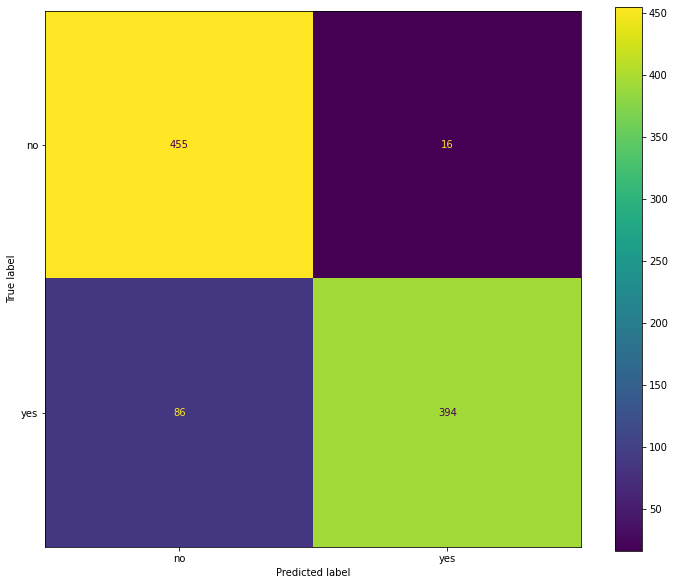

In [15]:
xd = return_cm(test_dataloader, model)

disp = ConfusionMatrixDisplay(xd, display_labels=yes_no_dataset.classes)
fig, ax = plt.subplots(figsize=(12, 10))
disp.plot(ax=ax)
plt.savefig('./results_yes_no/cm' + str(0.0001) +'.png')